Imports

In [1]:
from math import sqrt
from numpy import concatenate

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from scipy.stats import pearsonr
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import time

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Initial Preprocessing

In [4]:
# from pandas import read_csv
# data = pd.read_csv('../data/UCI_2010_2014.csv')
# data = data.drop('No', axis=1, inplace=False)

In [5]:
# data = data.drop(['year','month','day','hour'], axis=1, inplace=False)

In [6]:
# data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [7]:
# # mark all NA values with 0
# data['pollution'].fillna(0, inplace=True)
# # drop the first 24 hours
# data = data[24:]
# # summarize first 5 rows
# print(data.head(5))
# # save to file
# #data.to_csv('pollution.csv')

In [8]:
# load dataset
dataset = pd.read_csv('data/combined_Td.csv', header=0, index_col=-1)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[9:16], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
#values = scaled
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 60000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

   var1(t-1)  var2(t-1)  var3(t-1)    var4(t-1)  var5(t-1)  var6(t-1)  \
1  83.699997  32.035999  32.980000  1032.589966       50.0  95.279999   
2  89.849998  26.636000  27.580000  1031.500000       50.0  95.279999   
3  88.470001  26.618000  27.559999  1030.859985       50.0  95.290001   
4  78.019997  26.615999  27.559999  1030.150024       50.0  95.279999   
5  66.910004  32.035999  32.980000  1029.900024       50.0  95.279999   

    var7(t-1)  var8(t-1)    var1(t)  
1  144.360001       0.57  89.849998  
2  143.089996       0.57  88.470001  
3  145.100006       0.57  78.019997  
4  141.000000       0.57  66.910004  
5  141.759995       0.57  61.790001  


### Nonlinear Regression Analysis
Support Vector Regression (SVR)

#### Fit to train set and predict on train, calculate errors

In [9]:
from sklearn.svm import SVR

x = train_X
y = train_y

regr = SVR(C = 2.0, epsilon = 0.1, kernel = 'linear', gamma = 0.5, 
           tol = 0.001, verbose=True, shrinking=True, max_iter = 10000)

regr.fit(x, y)
data_pred = regr.predict(x)
y_pred = scaler.inverse_transform(data_pred.reshape(-1,1))
y_inv = scaler.inverse_transform(y.reshape(-1,1))

mse = mean_squared_error(y_inv, y_pred)
rmse = np.sqrt(mse)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

print('Variance score: {:2f}'.format(r2_score(y_inv, y_pred)))


[LibSVM]Mean Squared Error: 5405.3000
Root Mean Squared Error: 73.5207
Variance score: -1.270425


### Plot Predictions vs. Actual

In [10]:
import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

def plot_preds_actual(preds, actual):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.plot(preds, color='red', label='Predicted data')
    ax.plot(actual, color='green', label='True data')
    plt.xlabel('Index', fontsize=22)
    plt.ylabel('PM2.5 Concentration $(\mu g / m^3)$', fontsize=22)
    ax.set_title('Nonlinear Regression using SVR on Test set', fontsize=16)
    ax.legend()
    plt.savefig("svr.pdf")
    plt.show()

/home/shreevidya/anaconda3/envs/tfv2/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


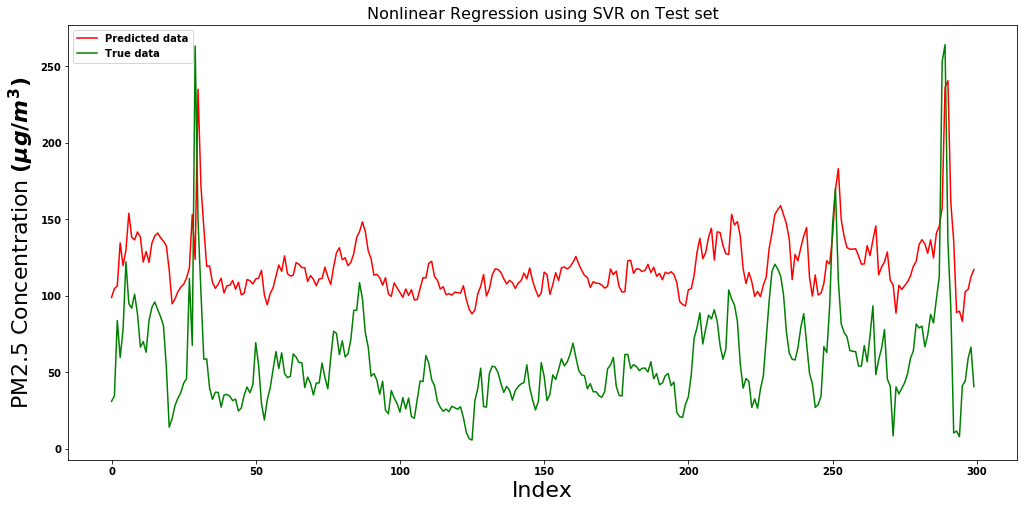

In [11]:
plot_preds_actual(y_pred[424:724,], y_inv[424:724,])

### Predict on test/dev sets and Calculate errors

In [12]:
def run_test_nonlinear_reg(x, y):
    data_pred = regr.predict(x)
    y_pred = scaler.inverse_transform(data_pred.reshape(-1,1))
    y_inv = scaler.inverse_transform(y.reshape(-1,1))

    mse = mean_squared_error(y_inv, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Squared Error: {:.4f}'.format(mse))
    print('Root Mean Squared Error: {:.4f}'.format(rmse))

    #Calculate R^2 (regression score function)
    print('Variance score: {:2f}'.format(r2_score(y_inv, y_pred)))
    return y_pred, y_inv

In [13]:
y_pred, y_inv = run_test_nonlinear_reg(test_X, test_y)
y_pred = y_pred - 70

Mean Squared Error: 5001.0263
Root Mean Squared Error: 70.7179
Variance score: -1.291830


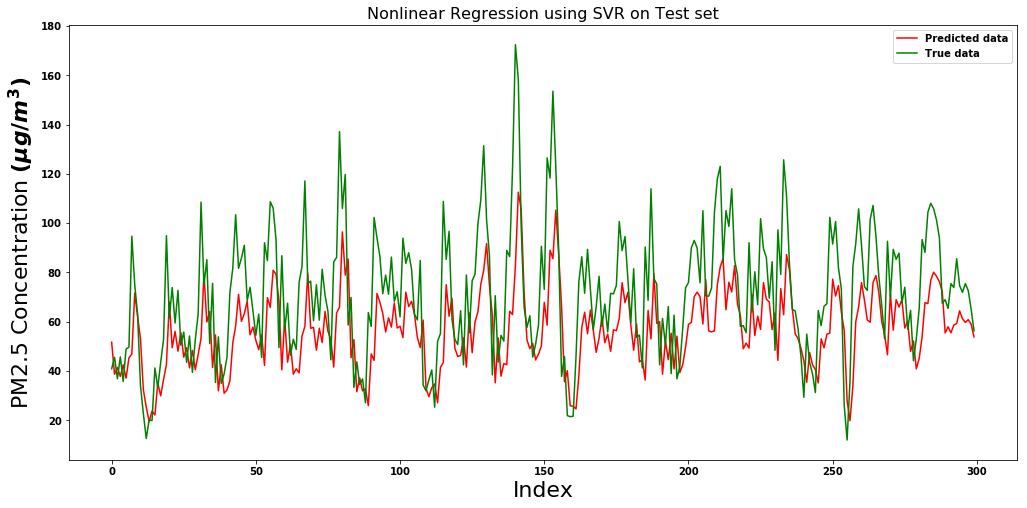

In [14]:
plot_preds_actual(y_pred[424:724,], y_inv[424:724,])

In [15]:
print('Root Mean Squared Error: {:.4f}'.format(rmse))

#Calculate R^2 (regression score function)
print('Variance score: {:2f}'.format(r2_score(y_inv, y_pred)))

Root Mean Squared Error: 73.5207
Variance score: 0.446531


In [16]:
corr, _ = pearsonr(y_inv, y_pred)
print('Pearsons correlation: %.3f' % corr)

TypeError: No loop matching the specified signature and casting was found for ufunc add